### Assignment Overview
<p>We will predict the class of breast cancer (malignant [‘bad’] versus benign [‘good’]) from the features taken from breast sample images.  
    
Support for breast cancer awareness and research has helped create advances in the diagnosis and treatment of breast cancer. Due to factors such as early detection, personalized treatment & better understanding of the disease, survival rates have increased & the number of deaths is steadily declining.</p>

![](images/bc.jpg)

### Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

### Data Ingestion

In [2]:
cols = "ID_number Clump_Thickness Cell_Size_Uniformity Cell_Shape_Uniformity Marginal_Adhesion Single_Epithelial_Cell_Size Bare_Nuclei Bland_Chromatin Normal_Nucleoli Mitoses Class"
cols_lst = cols.split()
filepath = "data/cancer.data"

In [3]:
bc = pd.read_csv(filepath, header=None, index_col=0, names=cols_lst)
bc.head(3)

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
ID_number,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2


### Inspecting Data

In [4]:
bc.describe()

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [5]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 1000025 to 897471
Data columns (total 10 columns):
Clump_Thickness                699 non-null int64
Cell_Size_Uniformity           699 non-null int64
Cell_Shape_Uniformity          699 non-null int64
Marginal_Adhesion              699 non-null int64
Single_Epithelial_Cell_Size    699 non-null int64
Bare_Nuclei                    699 non-null object
Bland_Chromatin                699 non-null int64
Normal_Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: int64(9), object(1)
memory usage: 60.1+ KB


- In pandas, objects are types that contain strings.
- Bare Nuclei is an object type indicating that it doesn't have just numeric values. This must be investigated.

In [6]:
bc['Bare_Nuclei'].value_counts()

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Bare_Nuclei, dtype: int64

In [7]:
bc = bc.replace('?', np.nan) 

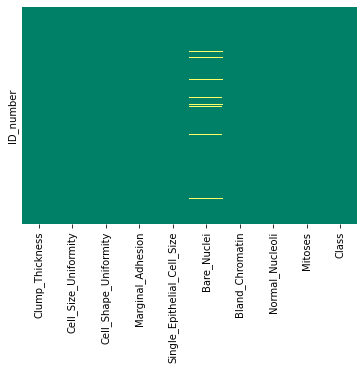

In [8]:
sns.heatmap(bc.isnull(),yticklabels=False,cbar=False,cmap='summer')
plt.show()

This heatmap reflects where missing values evaluate to 'True' in our dataset. Every yellow dash represents a missing value. 
It also serves to validate that only one column - Bare_Nuclei has missing values.

#### Dealing w/ Missing Values

In [9]:
# Iterate over each column of bc
for col in bc:
    # Check if the column is of object type
    if bc[col].dtypes == 'object':
        # Impute with the most frequent value
        bc = bc.fillna(bc[col].value_counts().index[0])

bc.isnull().sum()

Clump_Thickness                0
Cell_Size_Uniformity           0
Cell_Shape_Uniformity          0
Marginal_Adhesion              0
Single_Epithelial_Cell_Size    0
Bare_Nuclei                    0
Bland_Chromatin                0
Normal_Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [10]:
bc.Class.value_counts()

2    458
4    241
Name: Class, dtype: int64

## Model Preparation

In [11]:
X = bc.drop('Class',axis=1)
y = bc['Class']

### Binarizing Target Variable

Although 2 and 4 are numeric, we had to process them so that they're in a format our model can understand.


In [12]:
binary = {"Class": {2:0, 4:1}}
bc.replace(binary, inplace=True)


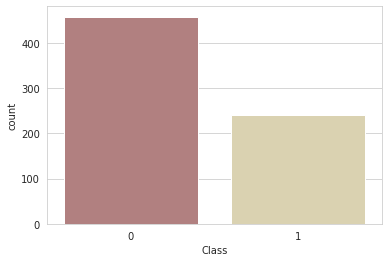

In [13]:
sns.set_style('whitegrid')
sns.countplot(x='Class',data=bc,palette='pink')
plt.show()

- Here we want to see the ratio of the target labels. 2= benign, 4= malignant
- There are more benign cells than malignant
<br> A way to address imbalanced classes is to oversample the minority class


### Class imbalance

In [14]:
print(pd.DataFrame(y).Class.value_counts(normalize=True))

0    0.655222
1    0.344778
Name: Class, dtype: float64


The above calculation shows that the majority class `0`( _benign_ ) constitutes  $\approx 67\%$ of the observations. `1`( _malignant_ ) is only  $\approx 34\%$.
The `smote` module from [imblearn](https://imbalanced-learn.readthedocs.io/en/stable/index.html) deals with this problem.

In [15]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=7)
X_sm, y_sm = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)

In [16]:
from sklearn.preprocessing import LabelEncoder 

le =  LabelEncoder()

# Iterate over all the values of each column and extract their dtypes
for col in bc:
    if bc[col].dtype=='object':
    # Use LabelEncoder to do the numeric transformation
        bc[col]=le.fit_transform(bc[col])

In [17]:
bc.dtypes

Clump_Thickness                int64
Cell_Size_Uniformity           int64
Cell_Shape_Uniformity          int64
Marginal_Adhesion              int64
Single_Epithelial_Cell_Size    int64
Bare_Nuclei                    int64
Bland_Chromatin                int64
Normal_Nucleoli                int64
Mitoses                        int64
Class                          int64
dtype: object

Objects have successfully been changed to integers

#### Creating Logistic Regesssion Model

In [18]:
logmodel = LogisticRegression()
#Fit model to data
logmodel.fit(X_train,y_train)

LogisticRegression()

__The logreg now holds a logistic regression model that is fit to the data.__

### Examining Coeficients & Intercepts

In [19]:
coef = logmodel.coef_
print(coef)

intercept = logmodel.intercept_
print(intercept)

[[0.6299658  0.11930471 0.14119808 0.21512862 0.08496943 0.53004013
  0.59923218 0.05356163 0.38021549]]
[-9.55876677]


It is interesting to have a look at the coefficients to check whether the model makes sense.

Given our fitted logistic regression model (logmodel), you can retrieve the coefficients using the attribute __coef_.__ The order in which the coefficients appear is the same as the order in which the variables were fed to the model. The intercept can be retrieved using the attribute __intercept_.__

For example, the coefficient associated with Clump Thickness is positive. This means it is positively correlated with the target.

### Predictions

In [21]:
y_pred = logmodel.predict(X_test)

# Get accuracy score of logreg model and print it
print("Accuracy of logistic regression classifier: ", logmodel.score(X_test, y_test))

Accuracy of logistic regression classifier:  0.96


In [ ]:
from sklearn.metrics import confusion_matrix
# confusion matrix of the logreg model
print(confusion_matrix(y_test, y_pred))

In [ ]:
from sklearn.metrics import classification_report
label= ['Benign', 'Malignant']
print(classification_report(y_test, y_pred, target_names=label))

### ROC Curve

A Receiver Operator Characteristic (ROC) curve is a graphical plot used to show the diagnostic ability of binary classifiers.
"It is nothing but a graph displaying the performance of a classification model. It is a very popular method to measure the accuracy of a classification model"

reference: https://towardsdatascience.com/roc-curve-in-machine-learning-fea29b14d133

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

logreg_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, threshold_log = roc_curve(y_test, y_pred)

In [ ]:
plt.plot(fpr, tpr, color='black', label='ROC')
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#### Overdispersion

Overdispersion is the presence of greater variability (statistical dispersion) in a data set than would be expected based on a given model.

In [ ]:
# !pip install scikitplot

In [ ]:
# import scikitplot as skplt
# import matplotlib.pyplot as plt

# y_true = probs[:,1]
# # ground truth labels
# y_probas = logreg.predict_proba(X_test)
# # predicted probabilities generated by sklearn classifier

# skplt.metrics.plot_roc_curve(y_true, y_probas)
# plt.show()

In [ ]:
# https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html

In [ ]:
# from sklearn.metrics import roc_curve

# fpr, tpr, threshold = roc_curve(y_test, logmodel.predict_proba(X_test))
# roc_auc = metrics.auc(fpr, tpr)

In [ ]:
# import sklearn.metrics as metrics
# # calculate the fpr and tpr for all thresholds of the classification
# probs = logmodel.predict_proba(X_test)
# preds = probs[:,1]
# fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
# # roc_auc = metrics.auc(fpr, tpr)

# # method I: plt
# import matplotlib.pyplot as plt
# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'ROC' )
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()